<a href="https://colab.research.google.com/github/HaardhikK/Arthantar/blob/main/test/Testing_Knowlege_Graph_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Knowledge graph
Spacy

In [ ]:
!pip install spacy networkx matplotlib
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


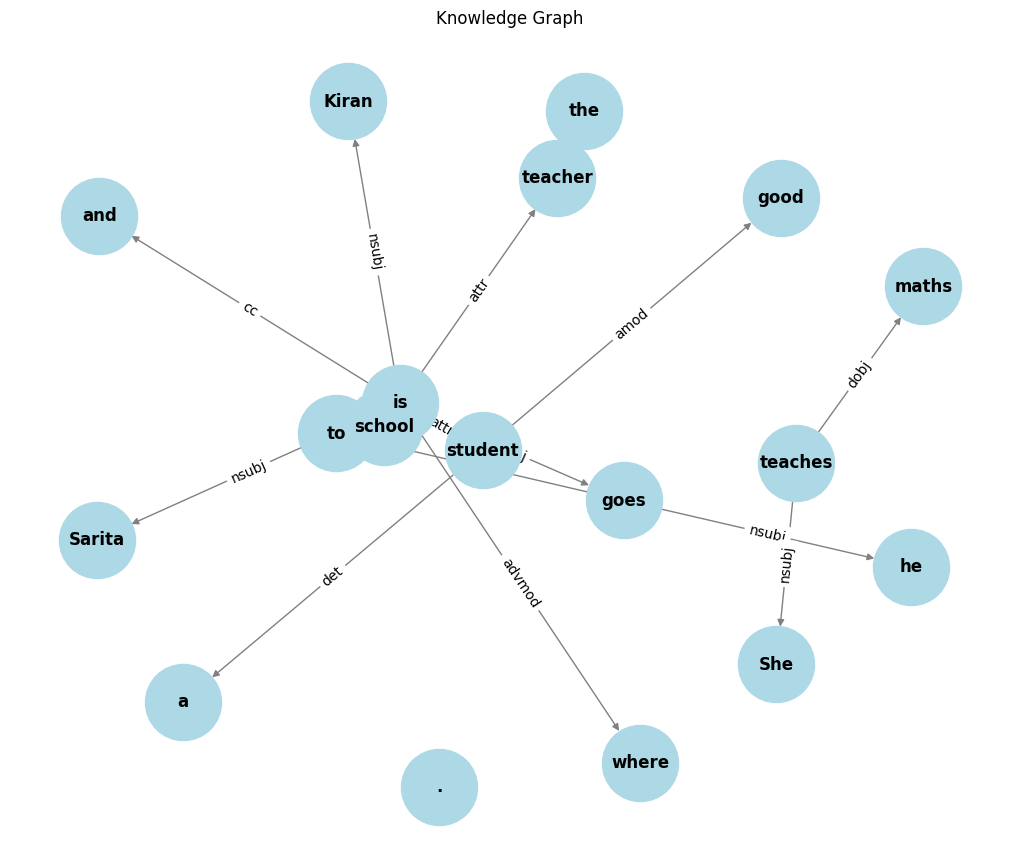

In [ ]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from spacy import displacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Sample sentence
sentence = "Kiran is a good student and he goes to school where Sarita is the teacher. She teaches maths."

# Process the text
doc = nlp(sentence)

# Create a directed graph for the Knowledge Graph
G = nx.DiGraph()

# Add nodes and edges based on dependencies and named entities
for token in doc:
    # Add entities to graph as nodes
    G.add_node(token.text)
    if token.dep_ != 'punct' and token.head != token:
        G.add_edge(token.head.text, token.text, relation=token.dep_)

# Plot the Knowledge Graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # for consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold', edge_color='gray')
labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Knowledge Graph")
plt.show()


In [ ]:
import spacy
import networkx as nx

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Sample sentence
sentence = "Kiran is a good student and he goes to school where Sarita is the teacher. She teaches maths."

# Process the text
doc = nlp(sentence)

# Create a directed graph for the Knowledge Graph
G = nx.DiGraph()

# Add nodes and edges based on dependencies and named entities
for token in doc:
    # Add entities to graph as nodes
    G.add_node(token.text)
    if token.dep_ != 'punct' and token.head != token:
        G.add_edge(token.head.text, token.text, relation=token.dep_)

# Print the Knowledge Graph in text format
print("Knowledge Graph:")
for u, v, data in G.edges(data=True):
    print(f"{u} --[{data['relation']}]--> {v}")


Knowledge Graph:
is --[nsubj]--> Kiran
is --[attr]--> student
is --[cc]--> and
is --[conj]--> goes
is --[advmod]--> where
is --[nsubj]--> Sarita
is --[attr]--> teacher
student --[det]--> a
student --[amod]--> good
goes --[nsubj]--> he
goes --[prep]--> to
to --[pobj]--> school
school --[relcl]--> is
teacher --[det]--> the
teaches --[nsubj]--> She
teaches --[dobj]--> maths


#Transformer

In [ ]:
%%capture
!pip install --upgrade --quiet  langchain langchain-community langchain-groq

In [ ]:
%%capture
!pip install --upgrade --quiet langchain_experimental

#Best attempt at knowledge graph yet(not any more)

In [ ]:
%%capture
!pip install --upgrade --quiet  langchain langchain-community langchain-groq

In [ ]:
%%capture
!pip install --upgrade --quiet langchain_experimental

In [ ]:
groq_api_key=""

In [ ]:
# mentions which model it is using
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json

class KnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "mixtral-8x7b-32768"):
        """Initialize the knowledge graph generator with Groq API"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)

    def create_graph_from_text(self, text: str) -> Dict:
     """Generate a knowledge graph from input text"""
     try:
        # Add minimum context for very short texts
        if len(text.split()) < 30:
            text = "Please analyze this short text and extract all possible relationships: " + text

        # Convert text to document format
        documents = [Document(page_content=text)]

        # Generate graph documents using LLM
        graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

        # Debug print to identify the graph source
        if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
            print("Using Basic Graph Generation.")
            return self._create_basic_graph(text)
        else:
            print("Using LLM-based Graph Generation.")

        # Extract nodes and relationships
        nodes = graph_documents[0].nodes if graph_documents[0].nodes else []
        relationships = graph_documents[0].relationships if graph_documents[0].relationships else []

        # Create NetworkX graph
        G = nx.DiGraph()

        # Add nodes to the graph
        for node in nodes:
            G.add_node(node.id, type=node.type, properties=node.properties)

        # Add edges (relationships) to the graph
        for rel in relationships:
            G.add_edge(
                rel.source.id,
                rel.target.id,
                type=rel.type,
                properties=rel.properties
            )

        # If graph is empty, fallback to basic graph
        if len(G.nodes()) == 0:
            print("LLM generated empty graph; switching to Basic Graph Generation.")
            return self._create_basic_graph(text)

        return {
            'nodes': [{'id': n, 'type': G.nodes[n]['type']} for n in G.nodes()],
            'relationships': [{'source': u,
                               'target': v,
                               'type': G.edges[u, v]['type']}
                              for u, v in G.edges()]
        }

     except Exception as e:
        print(f"Error in graph generation: {str(e)}")
        print("Switching to Basic Graph Generation due to an error.")
        return self._create_basic_graph(text)


    def _create_basic_graph(self, text: str) -> Dict:
        """Create a basic graph structure for cases where the LLM fails"""
        # Split the text into sentences
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()
        relationships = []

        # Extract basic entities (nouns) and relationships
        for sentence in sentences:
            words = sentence.split()
            # Add capitalized words as potential entities
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes
        for entity in entities:
            G.add_node(entity, type='Entity')

        # Add basic relationships between consecutive entities
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{'id': n, 'type': 'Entity'} for n in G.nodes()],
            'relationships': [{'source': u,
                             'target': v,
                             'type': G.edges[u, v]['type']}
                            for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("Knowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    # Sample text
    sample_text = "Kiran is a good student in a school where Jack is his the teacher. He goes to school regularly and she teaches maths."

    # Create graph generator instance
    kg_generator = KnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

Using LLM-based Graph Generation.
Knowledge Graph Structure:

Nodes:
- Kiran (Type: Student)
- School (Type: School)
- Jack (Type: Teacher)

Relationships:
- Kiran --[ATTENDS]--> School
- School --[HAS_TEACHER]--> Jack
- Jack --[TEACHES_AT]--> School
- Jack --[TEACHES]--> Kiran


In [ ]:
# mentions which model it is using
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json

class KnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "Gemma2-9b-It"):
        """Initialize the knowledge graph generator with Groq API"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)

    def create_graph_from_text(self, text: str) -> Dict:
     """Generate a knowledge graph from input text"""
     try:
        # Add minimum context for very short texts
        if len(text.split()) < 30:
            text = "Please analyze this short text and extract all possible relationships: " + text

        # Convert text to document format
        documents = [Document(page_content=text)]

        # Generate graph documents using LLM
        graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

        # Debug print to identify the graph source
        if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
            print("Using Basic Graph Generation.")
            return self._create_basic_graph(text)
        else:
            print("Using LLM-based Graph Generation.")

        # Extract nodes and relationships
        nodes = graph_documents[0].nodes if graph_documents[0].nodes else []
        relationships = graph_documents[0].relationships if graph_documents[0].relationships else []

        # Create NetworkX graph
        G = nx.DiGraph()

        # Add nodes to the graph
        for node in nodes:
            G.add_node(node.id, type=node.type, properties=node.properties)

        # Add edges (relationships) to the graph
        for rel in relationships:
            G.add_edge(
                rel.source.id,
                rel.target.id,
                type=rel.type,
                properties=rel.properties
            )

        # If graph is empty, fallback to basic graph
        if len(G.nodes()) == 0:
            print("LLM generated empty graph; switching to Basic Graph Generation.")
            return self._create_basic_graph(text)

        return {
            'nodes': [{'id': n, 'type': G.nodes[n]['type']} for n in G.nodes()],
            'relationships': [{'source': u,
                               'target': v,
                               'type': G.edges[u, v]['type']}
                              for u, v in G.edges()]
        }

     except Exception as e:
        print(f"Error in graph generation: {str(e)}")
        print("Switching to Basic Graph Generation due to an error.")
        return self._create_basic_graph(text)


    def _create_basic_graph(self, text: str) -> Dict:
        """Create a basic graph structure for cases where the LLM fails"""
        # Split the text into sentences
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()
        relationships = []

        # Extract basic entities (nouns) and relationships
        for sentence in sentences:
            words = sentence.split()
            # Add capitalized words as potential entities
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes
        for entity in entities:
            G.add_node(entity, type='Entity')

        # Add basic relationships between consecutive entities
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{'id': n, 'type': 'Entity'} for n in G.nodes()],
            'relationships': [{'source': u,
                             'target': v,
                             'type': G.edges[u, v]['type']}
                            for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("Knowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    # Sample text
    sample_text = "Kiran is a good student, and Sita is his science teacher, and he teaches him science."

    # Create graph generator instance
    kg_generator = KnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

Using LLM-based Graph Generation.
Knowledge Graph Structure:

Nodes:
- Kiran (Type: Person)
- Sita (Type: Person)

Relationships:
- Sita --[TEACHER]--> Kiran


In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json

class KnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "mixtral-8x7b-32768"):
        """Initialize the knowledge graph generator with Groq API"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text"""
        try:
            # Add minimum context for very short texts
            if len(text.split()) < 30:
                text = "Please analyze this short text and extract all possible relationships: " + text

            # Convert text to document format
            documents = [Document(page_content=text)]

            # Generate graph documents using LLM
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            # Handle empty graph documents
            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                return self._create_basic_graph(text)

            # Extract nodes and relationships
            nodes = graph_documents[0].nodes if graph_documents[0].nodes else []
            relationships = graph_documents[0].relationships if graph_documents[0].relationships else []

            # Create NetworkX graph
            G = nx.DiGraph()

            # Add nodes to the graph
            for node in nodes:
                G.add_node(node.id, type=node.type, properties=node.properties)

            # Add edges (relationships) to the graph
            for rel in relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            # If graph is empty, fallback to basic graph
            if len(G.nodes()) == 0:
                return self._create_basic_graph(text)

            return {
                'nodes': [{'id': n, 'type': G.nodes[n]['type']} for n in G.nodes()],
                'relationships': [{'source': u,
                                 'target': v,
                                 'type': G.edges[u, v]['type']}
                                for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text)

    def _create_basic_graph(self, text: str) -> Dict:
        """Create a basic graph structure for cases where the LLM fails"""
        # Split the text into sentences
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()
        relationships = []

        # Extract basic entities (nouns) and relationships
        for sentence in sentences:
            words = sentence.split()
            # Add capitalized words as potential entities
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes
        for entity in entities:
            G.add_node(entity, type='Entity')

        # Add basic relationships between consecutive entities
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{'id': n, 'type': 'Entity'} for n in G.nodes()],
            'relationships': [{'source': u,
                             'target': v,
                             'type': G.edges[u, v]['type']}
                            for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("Knowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    # Sample text
    sample_text = "Kiran is a good student and he goes to school where Sarita is the teacher. She teaches maths."

    # Create graph generator instance
    kg_generator = KnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

Knowledge Graph Structure:

Nodes:
- Kiran (Type: Student)
- School (Type: School)
- Sarita (Type: Teacher)
- Maths (Type: Subject)

Relationships:
- Kiran --[ATTENDS]--> School
- Sarita --[TEACHES_AT]--> School
- Sarita --[TEACHES]--> Maths


In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json

class KnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "mixtral-8x7b-32768"):
        """Initialize the knowledge graph generator with Groq API"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text"""
        try:
            # Add minimum context for very short texts
            if len(text.split()) < 30:
                text = "Please analyze this short text and extract all possible relationships: " + text

            # Convert text to document format
            documents = [Document(page_content=text)]

            # Generate graph documents using LLM
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            # Handle empty graph documents
            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                return self._create_basic_graph(text)

            # Extract nodes and relationships
            nodes = graph_documents[0].nodes if graph_documents[0].nodes else []
            relationships = graph_documents[0].relationships if graph_documents[0].relationships else []

            # Create NetworkX graph
            G = nx.DiGraph()

            # Add nodes to the graph
            for node in nodes:
                G.add_node(node.id, type=node.type, properties=node.properties)

            # Add edges (relationships) to the graph
            for rel in relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            # If graph is empty, fallback to basic graph
            if len(G.nodes()) == 0:
                return self._create_basic_graph(text)

            return {
                'nodes': [{'id': n, 'type': G.nodes[n]['type']} for n in G.nodes()],
                'relationships': [{'source': u,
                                 'target': v,
                                 'type': G.edges[u, v]['type']}
                                for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text)

    def _create_basic_graph(self, text: str) -> Dict:
        """Create a basic graph structure for cases where the LLM fails"""
        # Split the text into sentences
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()
        relationships = []

        # Extract basic entities (nouns) and relationships
        for sentence in sentences:
            words = sentence.split()
            # Add capitalized words as potential entities
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes
        for entity in entities:
            G.add_node(entity, type='Entity')

        # Add basic relationships between consecutive entities
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{'id': n, 'type': 'Entity'} for n in G.nodes()],
            'relationships': [{'source': u,
                             'target': v,
                             'type': G.edges[u, v]['type']}
                            for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("Knowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    # Sample text
    sample_text = """
    Albert Einstein was a German-born theoretical physicist who developed the theory of relativity.
    He worked at the Swiss Patent Office in Bern while conducting his research.
    Einstein received the Nobel Prize in Physics for his work on the photoelectric effect.
    """

    # Create graph generator instance
    kg_generator = KnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

Knowledge Graph Structure:

Nodes:
- Albert Einstein (Type: Person)
- German (Type: Country)
- Theoretical Physicist (Type: Profession)
- Swiss Patent Office (Type: Organization)
- Bern (Type: City)
- Nobel Prize In Physics (Type: Award)
- Photoelectric Effect (Type: Scientific_concept)

Relationships:
- Albert Einstein --[ORIGIN]--> German
- Albert Einstein --[PROFESSION]--> Theoretical Physicist
- Albert Einstein --[EMPLOYMENT]--> Swiss Patent Office
- Albert Einstein --[RECEIVED]--> Nobel Prize In Physics
- Albert Einstein --[WORK]--> Photoelectric Effect
- Swiss Patent Office --[LOCATION]--> Bern
